#Q-Learning

##enviroment

In [1]:


import numpy as np
import matplotlib



class Environment(object):
    def __init__(self, rownum=4, colnum=4, default = False):

        exceptions = np.array([[0,0],[0,1],[1,0],[1,1]])
        if default:
            self.rownum = 4
            self.colnum = 4
            self.matrix = np.zeros([self.rownum, self.colnum, 5])
            self.wumpus_locs = np.array([[0,2]])
            self.pit_locs = np.array([[2,0],[2,2],[3,3]])
            self.gold_locs = np.array([[1,2]])
        else:
            self.rownum = rownum
            self.colnum = colnum
            self.matrix = np.zeros([self.rownum, self.colnum, 5])
            self.gold_locs = self.generate_locations(1,exceptions)
            exceptions = np.concatenate([self.gold_locs,exceptions])
            self.wumpus_locs = self.generate_locations(int(self.rownum/2),exceptions)

        self.stench_locs = []
        for wumpus_loc in self.wumpus_locs:
            for loc in [[0,1],[1,0],[0,-1],[-1,0]]:
                new_loc = wumpus_loc+loc
                if not (np.sum(new_loc < 0) or sum(new_loc >= self.matrix.shape[:2])):
                    if new_loc.tolist() not in self.stench_locs:
                        self.stench_locs.append(new_loc.tolist())
        self.stench_locs = np.asarray(self.stench_locs)

        if not default:
            exceptions = np.concatenate([exceptions, self.wumpus_locs, self.stench_locs])
            self.pit_locs = self.generate_locations(3, exceptions)

        self.breeze_locs = []
        for pit_loc in self.pit_locs:
            for loc in [[0,1],[1,0],[0,-1],[-1,0]]:
                new_loc = pit_loc+loc
                if not (np.sum(new_loc < 0) or sum(new_loc >= self.matrix.shape[:2])):
                    if new_loc.tolist() not in self.breeze_locs:
                        self.breeze_locs.append(new_loc.tolist())
        self.breeze_locs = np.asarray(self.breeze_locs)

        self.place_objects()
        self.start_matrix = self.matrix.copy()

    def place_objects(self):
        for pos,loc in enumerate([self.wumpus_locs,self.pit_locs,self.stench_locs,
                              self.breeze_locs,self.gold_locs]):
            for i,j in loc:
                self.matrix[i][j][pos] = 1
    def reset_matrix(self):

     self.matrix = self.start_matrix.copy()

    # Return the initial state (assuming agent starts at (0, 0))
     return self.matrix

    def kill_wumpus(self,pos):

        self.matrix[tuple(pos)][0] = 0
        for loc in [[0, 1], [1, 0], [0, -1], [-1, 0]]:
            if not (np.sum(pos + loc < 0) or sum(pos + loc >= self.matrix.shape[:2])):
                self.matrix[tuple(pos + loc)][2] = 0

    def reset_matrix(self):

        self.matrix = self.start_matrix.copy()

    def generate_locations(self,n_loc,exceptions):
        exceptions = np.asarray(exceptions)
        locations = []
        for i in range(n_loc):
            while True:
                x, y = np.random.randint(self.rownum), np.random.randint(self.colnum)
                if not ([x,y] == exceptions).all(1).any() and [x,y] not in locations:
                    locations.append([x,y])
                    break
        return(np.array(locations))







now we are going to test this enviroment

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib


env = Environment(default=True)


print("Initial Matrix:")
print(env.matrix)


print("Wumpus Locations:")
print(env.wumpus_locs)


print("Pit Locations:")
print(env.pit_locs)


print("Gold Locations:")
print(env.gold_locs)


print("Stench Locations:")
print(env.stench_locs)


print("Breeze Locations:")
print(env.breeze_locs)




env.reset_matrix()


print("Matrix after reset:")
print(env.matrix)


Initial Matrix:
[[[0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]]]
Wumpus Locations:
[[0 2]]
Pit Locations:
[[2 0]
 [2 2]
 [3 3]]
Gold Locations:
[[1 2]]
Stench Locations:
[[0 3]
 [1 2]
 [0 1]]
Breeze Locations:
[[2 1]
 [3 0]
 [1 0]
 [2 3]
 [3 2]
 [1 2]]
Matrix after reset:
[[[0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]]]


##agent

In [12]:
class Agent(object):
    def __init__(self, Environment, learning_rate=0.1, discount_factor=0.9, random_factor=0.01,
                 reward_dic=None, debug=False):
        # Set default rewards
        default_r = [('win', 100), ('wumpus_killed', 50), ('death', -1000), ('move_nothing', -1), ('shoot_nothing', 0)]
        # If no reward dictionary is provided, use the default rewards
        self.reward_dic = dict(default_r) if not reward_dic else reward_dic if type(reward_dic) == dict else dict(reward_dic)

        # Initial settings for the agent
        self.env = Environment
        self.start_matrix = self.env.start_matrix.copy()
        self.debug = debug
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.random_factor = random_factor

        # State and history settings
        self.step, self.history, self.action_history = 0, [], []
        self.state = np.array([0, 0, 1, 0])  # Initial state of the agent
        self.arrowpos = self.state[:2].copy()  # Position of the agent's arrow

        # Map and Q-Table settings
        self.map = np.zeros(self.env.matrix.shape)  # Environment map as a zero array
        self.qtable = np.zeros(self.env.matrix.shape[:2] + (8,))  # Q-Table as a zero array with dimensions [rows, cols, 8]
        self.rewards = np.zeros(self.env.matrix.shape[:2] + (8,))  # Rewards table as a zero array with dimensions [rows, cols, 8]

        # Directions and actions settings
        self.dir_dic = {'left': [-1, 0], 'right': [1, 0], 'down': [0, -1], 'up': [0, 1]}
        actions = ['move_' + d for d in self.dir_dic.keys()] + ['shoot_' + d for d in self.dir_dic.keys()]
        self.action_map = dict([(j, i) for (i, j) in enumerate(actions)])

        # Win and death counters
        self.wins, self.deaths = 0, 0


    def eval_actions(self, state):

        available_actions = []
        for d in self.dir_dic.keys():
            newpos = state[:2] + self.dir_dic[d]
            if not (np.sum(newpos < 0) or np.sum(newpos >= self.env.matrix.shape[:2])):
                available_actions.append('move_' + d)
                if state[2] == 1:
                    available_actions.append('shoot_' + d)
        return(available_actions)

    def take_action(self,action):

        self.step += 1
        act,direction = action.split('_')
        if act == 'move':
            if self.debug:
                q_value = self.qtable[tuple(self.state[:2])][self.action_map[action]]
                print('Move %s on %s (%s)'%(direction,self.state[:2],q_value))
            result = self.move(direction)
        elif act == 'shoot':
            if self.debug:
                q_value = self.qtable[tuple(self.state[:2])][self.action_map[action]]
                print('Shoot %s on %s %s'%(direction,self.state[:2],q_value))
            result = self.shoot(direction)
        self.action_history.append(action)
        return(result)

    def reset_state(self):

        self.state = np.array([0,0,1,0])
        self.arrowpos = self.state[:2].copy()
        self.env.reset_matrix()

    def reset_knowlegde(self):
        self.qtable = np.zeros(self.env.matrix.shape[:2]+(8,))
        self.rewards = np.zeros(self.env.matrix.shape[:2]+(8,))
        self.step, self.history, self.action_history = 0, [], []
        self.wins, self.deaths = 0, 0

    def move(self,direction):

        oldstate = self.state.copy()
        action_ix = self.action_map['move_'+direction]
        self.state[:2] += self.dir_dic[direction]
        obj = self.env.matrix[tuple(self.state[:2])]
        self.map[tuple(self.state[:2])] = self.env.matrix[tuple(self.state[:2])]
        if obj[0] == 1 or obj[1] == 1: # szörnyre, vagy szakadékba lép: -10
            result = 'You died!'
            if self.debug: print('You died on %s.'%self.state[:2])
            self.history.append(self.reward_dic['death'])
            self.reset_state()
            self.rewards[(tuple(oldstate[:2]))][action_ix] = self.reward_dic['death']
            self.deaths += 1
        elif obj[4] == 1: # Aranyat talál: +100
            result = 'Gold found!'
            if self.debug: print('You won on %s.'%self.state[:2])
            self.history.append(self.reward_dic['win'])
            self.reset_state()
            self.rewards[(tuple(oldstate[:2]))][action_ix] = self.reward_dic['win']
            self.wins += 1
        else: # Nem történik semmi: -1
            result = 'nope'
            self.history.append(self.reward_dic['move_nothing'])
            self.rewards[(tuple(oldstate[:2])),action_ix] = self.reward_dic['move_nothing']
        self.update_qtable(oldstate,self.state,action_ix)
        self.update_arrowpos()
        return(result)

    def shoot(self,direction):

        oldstate = self.state.copy()
        action_ix = self.action_map['shoot_'+direction]
        self.state[2] = 0
        self.arrowpos += self.dir_dic[direction]
        if (self.arrowpos == self.env.wumpus_locs).all(1).any():
            result = 'Wumpus died!'
            if self.debug: print('Wumpus died.')
            self.state[3] = 1
            self.env.kill_wumpus(self.arrowpos)
            self.rewards[(tuple(oldstate[:2]))][action_ix] = self.reward_dic['wumpus_killed']
            self.history.append(self.reward_dic['wumpus_killed'])
        else:
            result = 'nope'
            if self.debug: print('Nothing happened.')
            self.history.append(self.reward_dic['shoot_nothing'])
            self.rewards[(tuple(self.state[:2]))][action_ix] = self.reward_dic['shoot_nothing']
        self.update_qtable(oldstate,self.state,action_ix)
        self.arrowpos = None
        return(result)

    def update_arrowpos(self):
        if self.state[2]:
            self.arrowpos = self.state[:2].copy()

    def update_qtable(self, state, next_state, action_ix):

        pos, next_pos = tuple(state[:2]), tuple(next_state[:2])
        r = self.rewards[pos][action_ix]
        q = self.qtable[pos][action_ix]
        available_actions = np.array([self.action_map[a] for a in self.eval_actions(self.state)])
        qmax = np.max(self.qtable[next_pos][available_actions ])
        new_q = q + self.learning_rate * (r + self.discount_factor * qmax - q)
        self.qtable[pos][action_ix] = new_q

    def get_best_action(self):

        best = np.random.choice(self.eval_actions(self.state))
        if not np.random.uniform(0,1) < self.random_factor:
            available_actions = np.array([self.action_map[a] for a in self.eval_actions(self.state)])
            if not (self.qtable[tuple(self.state[:2])][available_actions] == 0).all():
                max_q_loc = np.where(self.qtable[tuple(self.state[:2])] == \
                                     max(self.qtable[tuple(self.state[:2])][available_actions]))
                max_q_loc = np.intersect1d(available_actions,max_q_loc[0])
                if len(max_q_loc) > 1:
                    action_ix = np.random.choice(max_q_loc)
                else:
                    action_ix = max_q_loc
                for action, ix in self.action_map.items():
                    if ix == action_ix:
                        best = action
        return(best)

    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_discount_factor(self, discount_factor):
        self.discount_factor = discount_factor

    def set_random_factor(self,random_factor):
        self.random_factor = random_factor

In [13]:

import numpy as np
import pandas as pd
import matplotlib



def train_agent(agent, episodes=1000, exploration_decay=0.99, epsilon_decay=0.995, min_epsilon=0.01, print_interval=100):
    global rewards_per_episode
    winning_steps = []
    rewards_per_episode = []
    mean_rewards = []

    for episode in range(episodes):
        agent.reset_state()
        agent.set_random_factor(max(min_epsilon, agent.random_factor * epsilon_decay))  # Decay exploration rate
        done = False
        steps = 0
        episode_reward = 0
        while not done and steps < 100:  # Limit steps to 100 per episode
            action = agent.get_best_action()
            result = agent.take_action(action)
            episode_reward += agent.rewards[tuple(agent.state[:2])][agent.action_map[action]]
            steps += 1
            if result in ['You died!', 'Gold found!']:
                done = True
                if result == 'Gold found!':
                    winning_steps.append((episode, steps))

        rewards_per_episode.append(episode_reward)

        # Print training progress and calculate mean reward at specified intervals
        if (episode + 1) % print_interval == 0:
            mean_reward = np.mean(rewards_per_episode[-print_interval:])
            mean_rewards.append(mean_reward)
            print(f'Episode {episode + 1}: Wins={agent.wins}, Deaths={agent.deaths}, Mean Reward={mean_reward:.2f}, Epsilon={agent.random_factor:.4f}')

    print('Training completed')
    print(f'Total Wins: {agent.wins}, Total Deaths: {agent.deaths}')

    if winning_steps:
        first_win_episode, steps_to_win = winning_steps[0]
        print(f'Agent first learned how to win at episode {first_win_episode} after {steps_to_win} steps.')

    print_final_qtable(agent.qtable)

def print_final_qtable(qtable):
    actions = ['move_left', 'move_right', 'move_down', 'move_up', 'shoot_left', 'shoot_right', 'shoot_down', 'shoot_up']
    data = []

    for row in range(qtable.shape[0]):
        for col in range(qtable.shape[1]):
            state_qvalues = [f'({row},{col})'] + list(qtable[row, col])
            data.append(state_qvalues)

    df = pd.DataFrame(data, columns=['State'] + actions)
    print(df)

    # Optionally, save the dataframe to a CSV file
    df.to_csv('qtable.csv', index=False)

# Example usage
if __name__ == "__main__":
    env = Environment(default=True)
    agent = Agent(env, learning_rate=0.1, discount_factor=0.9, random_factor=0.1, debug=False)
    train_agent(agent)


Episode 100: Wins=95, Deaths=5, Mean Reward=-40.14, Epsilon=0.0606
Episode 200: Wins=194, Deaths=6, Mean Reward=-16.02, Epsilon=0.0367
Episode 300: Wins=293, Deaths=7, Mean Reward=-122.80, Epsilon=0.0222
Episode 400: Wins=393, Deaths=7, Mean Reward=96.95, Epsilon=0.0135
Episode 500: Wins=493, Deaths=7, Mean Reward=98.00, Epsilon=0.0100
Episode 600: Wins=593, Deaths=7, Mean Reward=98.00, Epsilon=0.0100
Episode 700: Wins=693, Deaths=7, Mean Reward=98.00, Epsilon=0.0100
Episode 800: Wins=793, Deaths=7, Mean Reward=98.00, Epsilon=0.0100
Episode 900: Wins=893, Deaths=7, Mean Reward=96.97, Epsilon=0.0100
Episode 1000: Wins=993, Deaths=7, Mean Reward=98.99, Epsilon=0.0100
Training completed
Total Wins: 993, Total Deaths: 7
Agent first learned how to win at episode 4 after 4 steps.
    State   move_left  move_right  move_down     move_up  shoot_left  \
0   (0,0)    0.000000  291.870462   0.000000   45.811782    0.000000   
1   (0,1)    0.000000  176.038360  -0.231319 -190.000000    0.000000   

In [12]:
df = pd.read_csv('/content/qtable.csv')
df

,State,move_left,move_right,move_down,move_up,shoot_left,shoot_right,shoot_down,shoot_up
0,"(0,0)",0.000000,291.870760,0.000000,33.067076,0.000000,123.817959,0.0000,76.361313
1,"(0,1)",0.000000,156.620029,-0.215200,-100.000000,0.000000,0.000000,0.0000,0.000000
2,"(0,2)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
3,"(0,3)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
4,"(1,0)",46.987281,-372.241647,0.000000,325.413233,29.262453,98.377901,0.0000,99.105574
5,"(1,1)",11.596984,8.842304,78.368588,362.682644,110.904627,28.744520,141.0678,58.843892
6,"(1,2)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
7,"(1,3)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
8,"(2,0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
9,"(2,1)",84.040348,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


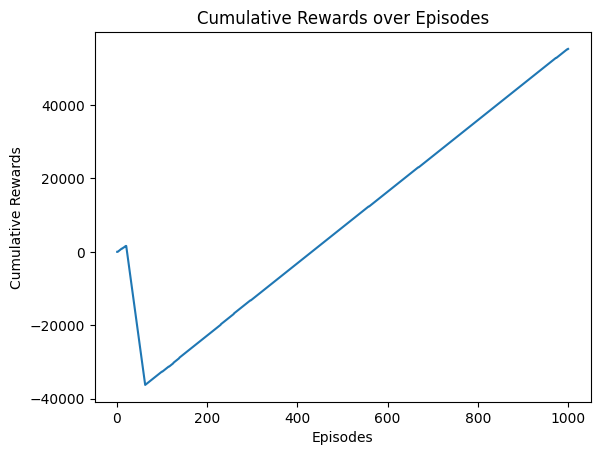

In [ ]:

import matplotlib.pyplot as plt

# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards_per_episode)

# Plot cumulative rewards
plt.plot(range(1, len(cumulative_rewards) + 1), cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards over Episodes')
plt.show()


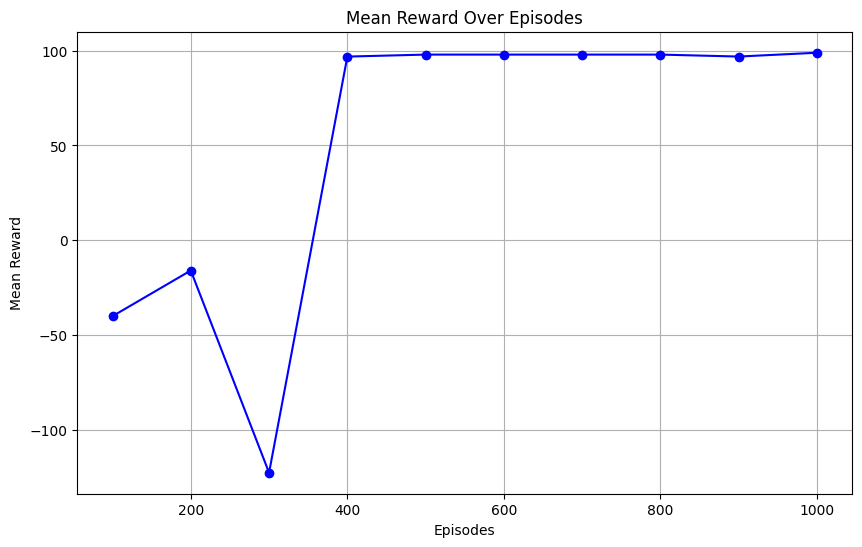

In [14]:
import matplotlib.pyplot as plt

# Data
episodes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
mean_rewards = [-40.14, -16.02, -122.80, 96.95, 98.00, 98.00, 98.00, 98.00, 96.97, 98.99]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_rewards, marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Mean Reward Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')

# Displaying the plot
plt.grid(True)
plt.show()


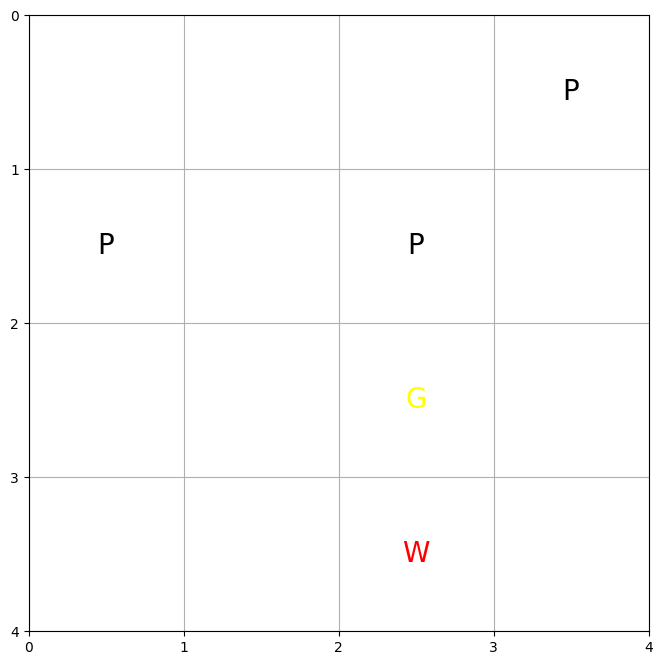

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class Environment(object):
    def __init__(self, rownum=4, colnum=4, default=False):
        exceptions = np.array([[0,0],[0,1],[1,0],[1,1]])
        if default:
            self.rownum = 4
            self.colnum = 4
            self.matrix = np.zeros([self.rownum, self.colnum, 5])
            self.wumpus_locs = np.array([[0,2]])
            self.pit_locs = np.array([[2,0],[2,2],[3,3]])
            self.gold_locs = np.array([[1,2]])
        else:
            self.rownum = rownum
            self.colnum = colnum
            self.matrix = np.zeros([self.rownum, self.colnum, 5])
            self.gold_locs = self.generate_locations(1,exceptions)
            exceptions = np.concatenate([self.gold_locs,exceptions])
            self.wumpus_locs = self.generate_locations(int(self.rownum/2),exceptions)

        self.stench_locs = []
        for wumpus_loc in self.wumpus_locs:
            for loc in [[0,1],[1,0],[0,-1],[-1,0]]:
                new_loc = wumpus_loc+loc
                if not (np.sum(new_loc < 0) or sum(new_loc >= self.matrix.shape[:2])):
                    if new_loc.tolist() not in self.stench_locs:
                        self.stench_locs.append(new_loc.tolist())
        self.stench_locs = np.asarray(self.stench_locs)

        if not default:
            exceptions = np.concatenate([exceptions, self.wumpus_locs, self.stench_locs])
            self.pit_locs = self.generate_locations(3, exceptions)

        self.breeze_locs = []
        for pit_loc in self.pit_locs:
            for loc in [[0,1],[1,0],[0,-1],[-1,0]]:
                new_loc = pit_loc+loc
                if not (np.sum(new_loc < 0) or sum(new_loc >= self.matrix.shape[:2])):
                    if new_loc.tolist() not in self.breeze_locs:
                        self.breeze_locs.append(new_loc.tolist())
        self.breeze_locs = np.asarray(self.breeze_locs)

        self.place_objects()
        self.start_matrix = self.matrix.copy()

    def place_objects(self):
        for pos,loc in enumerate([self.wumpus_locs,self.pit_locs,self.stench_locs,
                              self.breeze_locs,self.gold_locs]):
            for i,j in loc:
                self.matrix[i][j][pos] = 1

    def generate_locations(self, n_loc, exceptions):
        exceptions = np.asarray(exceptions)
        locations = []
        for i in range(n_loc):
            while True:
                x, y = np.random.randint(self.rownum), np.random.randint(self.colnum)
                if not ([x, y] == exceptions).all(1).any() and [x, y] not in locations:
                    locations.append([x, y])
                    break
        return(np.array(locations))

# ایجاد محیط پیش‌فرض
env = Environment(default=True)

# رسم محیط
def plot_environment(env):
    plt.figure(figsize=(8, 8))
    plt.grid(True)
    plt.xlim(0, env.colnum)
    plt.ylim(0, env.rownum)

    # رسم طلا
    for loc in env.gold_locs:
        plt.text(loc[1] + 0.5, env.rownum - loc[0] - 0.5, 'G', ha='center', va='center', fontsize=20, color='yellow')

    # رسم چاله‌ها
    for loc in env.pit_locs:
        plt.text(loc[1] + 0.5, env.rownum - loc[0] - 0.5, 'P', ha='center', va='center', fontsize=20, color='black')

    # رسم ومپوس‌ها
    for loc in env.wumpus_locs:
        plt.text(loc[1] + 0.5, env.rownum - loc[0] - 0.5, 'W', ha='center', va='center', fontsize=20, color='red')

    # تنظیمات اضافی برای نمایش بهتر
    plt.xticks(np.arange(env.colnum + 1))
    plt.yticks(np.arange(env.rownum + 1))
    plt.gca().invert_yaxis()
    plt.show()

# فراخوانی تابع رسم محیط
plot_environment(env)


#Deep Q-Learning

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.losses import Huber

class GridWorld:
    def __init__(self):
        self.size = 4
        self.grid = np.zeros((self.size, self.size))
        self.agent_start = (0, 0)
        self.gold_location = (3, 3)
        self.wumpus_location = (1, 3)
        self.pit_positions = [(1, 1), (2, 2)]
        self.arrow_available = True
        self.wumpus_alive = True
        self.reset()

    def reset(self):
        self.agent_pos = self.agent_start
        self.arrow_available = True
        self.wumpus_alive = True
        return self.get_state()

    def step(self, action):
        x, y = self.agent_pos
        reward = -1
        done = False

        if action == 0:  # up
            x = max(0, x - 1)
        elif action == 1:  # down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # left
            y = max(0, y - 1)
        elif action == 3:  # right
            y = min(self.size - 1, y + 1)
        elif action == 4 and self.arrow_available:  # shoot up
            self.arrow_available = False
            if any(self.wumpus_location == (i, y) for i in range(x)):
                reward = 50
                self.wumpus_alive = False
        elif action == 5 and self.arrow_available:  # shoot down
            self.arrow_available = False
            if any(self.wumpus_location == (i, y) for i in range(x + 1, self.size)):
                reward = 50
                self.wumpus_alive = False
        elif action == 6 and self.arrow_available:  # shoot left
            self.arrow_available = False
            if any(self.wumpus_location == (x, j) for j in range(y)):
                reward = 50
                self.wumpus_alive = False
        elif action == 7 and self.arrow_available:  # shoot right
            self.arrow_available = False
            if any(self.wumpus_location == (x, j) for j in range(y + 1, self.size)):
                reward = 50
                self.wumpus_alive = False

        self.agent_pos = (x, y)

        if self.agent_pos == self.gold_location:
            reward = 100
            done = True
        elif self.agent_pos in self.pit_positions:
            reward = -1000
            done = True
        elif self.agent_pos == self.wumpus_location and self.wumpus_alive:
            reward = -1000
            done = True

        return self.get_state(), reward, done

    def get_state(self):
        state = np.zeros((self.size, self.size, 5))
        state[self.agent_pos][0] = 1
        state[self.gold_location][1] = 1
        for pit in self.pit_positions:
            state[pit][3] = 1
        state[:, :, 4] = int(self.arrow_available)
        return state.flatten()

class ExperienceReplay:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.states = np.zeros((capacity,) + state_shape, dtype=np.float32)
        self.actions = np.zeros(capacity, dtype=np.int32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity,) + state_shape, dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.bool_)
        self.index = 0
        self.current_size = 0

    def store(self, state, action, reward, next_state, done):
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = done
        self.index = (self.index + 1) % self.capacity
        self.current_size = min(self.current_size + 1, self.capacity)

    def sample(self, batch_size):
        indices = np.random.choice(self.current_size, batch_size, replace=False)
        return (self.states[indices], self.actions[indices], self.rewards[indices],
                self.next_states[indices], self.dones[indices])

class DQNetworkAgent:
    def __init__(self, learning_rate, gamma, state_shape, num_actions, batch_size,
                 epsilon_initial=1.0, epsilon_decay=0.995, epsilon_final=0.05,
                 replay_buffer_capacity=1000):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.epsilon = epsilon_initial
        self.epsilon_decay = epsilon_decay
        self.epsilon_final = epsilon_final
        self.buffer = ExperienceReplay(replay_buffer_capacity, state_shape)
        self.q_network = self._build_model(state_shape, num_actions)
        self.target_network = self._build_model(state_shape, num_actions)
        self.update_target_network()

    def _build_model(self, state_shape, num_actions):
        model = keras.Sequential([
            keras.layers.Dense(128, activation='relu', input_shape=state_shape),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(num_actions, activation=None)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss=Huber())
        return model

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.num_actions)
        else:
            q_values = self.q_network.predict(state[np.newaxis])
            action = np.argmax(q_values[0])
        return action

    def train(self, env, episodes):
        total_rewards, cumulative_rewards = [], []
        for episode in range(episodes):
            state = env.reset()
            done, total_reward = False, 0
            while not done:
                action = self.select_action(state)
                next_state, reward, done = env.step(action)
                self.buffer.store(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                if self.buffer.current_size >= self.batch_size:
                    self.replay()

            self.update_epsilon()
            self.update_target_network()
            total_rewards.append(total_reward)
            cumulative_rewards.append(total_reward if not cumulative_rewards else cumulative_rewards[-1] + total_reward)
            print(f'Episode {episode+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon}')

        mean_rewards = np.cumsum(total_rewards) / (np.arange(len(total_rewards)) + 1)
        self.save_rewards_data(total_rewards, cumulative_rewards, mean_rewards)

        print(f'Training - Number of deaths: {sum(r < 0 for r in total_rewards)}')
        print(f'Training - Total rewards: {sum(total_rewards)}')
        print(f'Training - Highest reward: {max(total_rewards)}')
        print(f'Training - Lowest reward: {min(total_rewards)}')
        print(f'Training - Accuracy: {sum(r > 0 for r in total_rewards) / len(total_rewards) * 100:.2f}%')

        return total_rewards, cumulative_rewards, mean_rewards

    def replay(self):
        if self.buffer.current_size < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        q_values_current = self.q_network.predict(states)
        q_values_next = self.target_network.predict(next_states)

        targets = q_values_current.copy()
        batch_indices = np.arange(self.batch_size, dtype=np.int32)
        targets[batch_indices, actions] = rewards + self.gamma * np.amax(q_values_next, axis=1) * (1 - dones)

        self.q_network.train_on_batch(states, targets)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)

    def save_rewards_data(self, total_rewards, cumulative_rewards, mean_rewards):
        data = {
            "Episode": np.arange(len(total_rewards)),
            "Total Reward": total_rewards,
            "Cumulative Reward": cumulative_rewards,
            "Mean Reward": mean_rewards
        }

        df = pd.DataFrame(data)
        df.to_csv("dqn_training_rewards.csv", index=False)

    def save_model(self, model_path):
        self.q_network.save(model_path)

    def load_model(self, model_path):
        self.q_network = keras.models.load_model(model_path)
        self.update_target_network()

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Episode 790/1000, Total Reward: 144, Epsilon: 0.05
2/2 [==============================] - 0s 7ms/step
Episode 791/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 4ms/step
Episode 792/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 5ms/step
Episode 793/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 5ms/step
Episode 794/1000, Total Reward: 144, Epsilon: 0.05
2/2 [==============================] - 0s 9ms/step
Episode 795/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 6ms/step
Episode 796/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 6ms/step
Episode 797/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 5ms/step
Episode 798/1000, Total Reward: 145, Epsilon: 0.05
2/2 [==========================

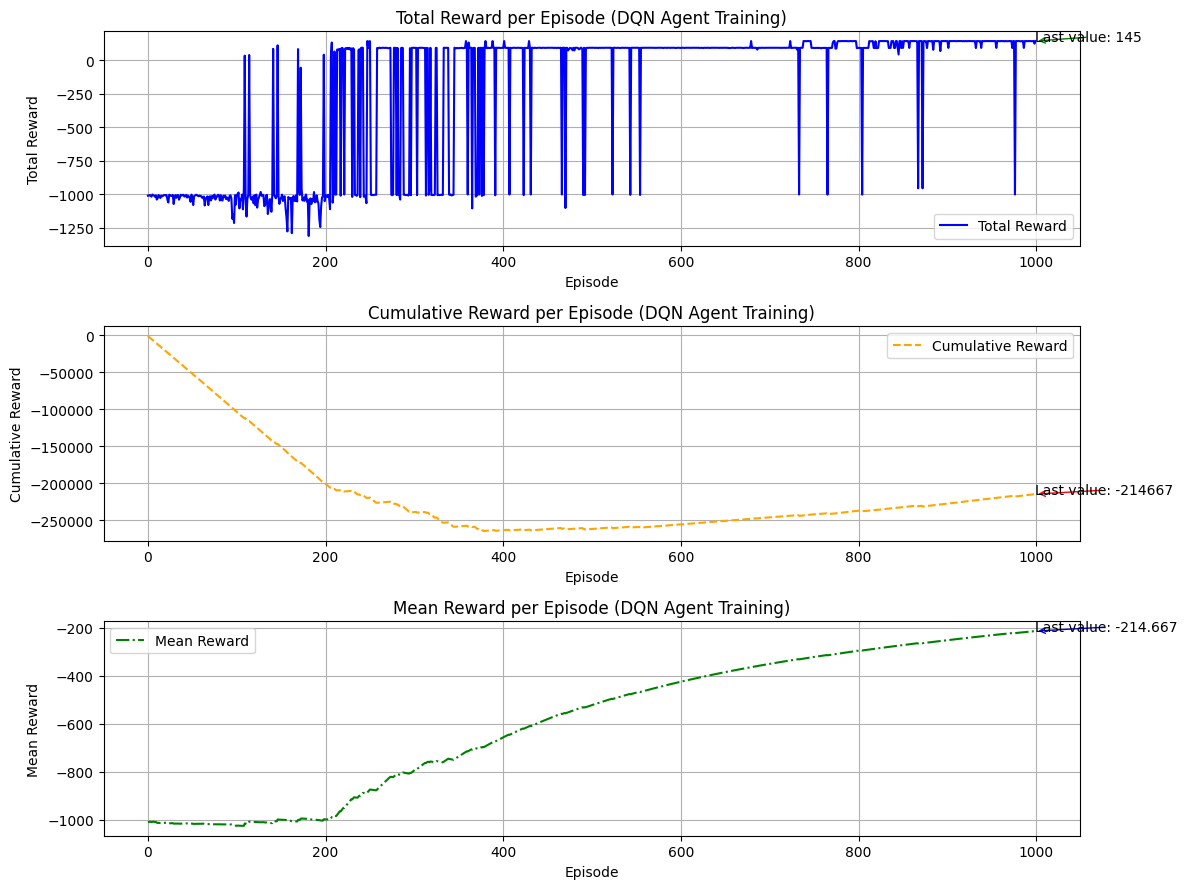

In [4]:
def plot_rewards(total_rewards, cumulative_rewards, mean_rewards, title, filename):
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))

    axs[0].plot(total_rewards, label='Total Reward', color='blue', linestyle='-')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode ({title})')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].annotate(f'Last value: {total_rewards[-1]}', xy=(len(total_rewards)-1, total_rewards[-1]),
                    xytext=(len(total_rewards)-1, total_rewards[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color='green'))

    axs[1].plot(cumulative_rewards, label='Cumulative Reward', color='orange', linestyle='--')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Cumulative Reward')
    axs[1].set_title(f'Cumulative Reward per Episode ({title})')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].annotate(f'Last value: {cumulative_rewards[-1]}', xy=(len(cumulative_rewards)-1, cumulative_rewards[-1]),
                    xytext=(len(cumulative_rewards)-1, cumulative_rewards[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color='red'))

    axs[2].plot(mean_rewards, label='Mean Reward', color='green', linestyle='-.')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Mean Reward')
    axs[2].set_title(f'Mean Reward per Episode ({title})')
    axs[2].legend()
    axs[2].grid(True)
    axs[2].annotate(f'Last value: {mean_rewards[-1]}', xy=(len(mean_rewards)-1, mean_rewards[-1]),
                    xytext=(len(mean_rewards)-1, mean_rewards[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color='blue'))

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Initialize the environment
env = GridWorld()

# Define hyperparameters
learning_rate = 1e-4
gamma = 0.99
state_shape = (env.size * env.size * 5,)
actions = 8
batch_size = 64

# Create the agent
agent = DQNetworkAgent(learning_rate, gamma, state_shape, actions, batch_size)

# Train the agent
episodes = 1000
total_rewards, cumulative_rewards, mean_rewards = agent.train(env, episodes)

# Plot the results
plot_rewards(total_rewards, cumulative_rewards, mean_rewards, "DQN Agent Training", "dqn_training_rewards.png")

# DQN results for Comparison part:
DQNtotal_rewards = total_rewards
DQNcumulative_rewards = cumulative_rewards
DQNmean_rewards = mean_rewards



Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Episode 1836/2000, Total Reward: 143, Epsilon: 0.05
2/2 [==============================] - 0s 5ms/step
Episode 1837/2000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 4ms/step
Episode 1838/2000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 6ms/step
Episode 1839/2000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 6ms/step
Episode 1840/2000, Total Reward: 143, Epsilon: 0.05
2/2 [==============================] - 0s 5ms/step
Episode 1841/2000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 9ms/step
Episode 1842/2000, Total Reward: 145, Epsilon: 0.05
2/2 [==============================] - 0s 6ms/step
Episode 1843/2000, Total Reward: -1462, Epsilon: 0.05
2/2 [==============================] - 0s 5ms/step
Episode 1844/2000, Total Reward: 145, Epsilon: 0.05
2/2 [===============

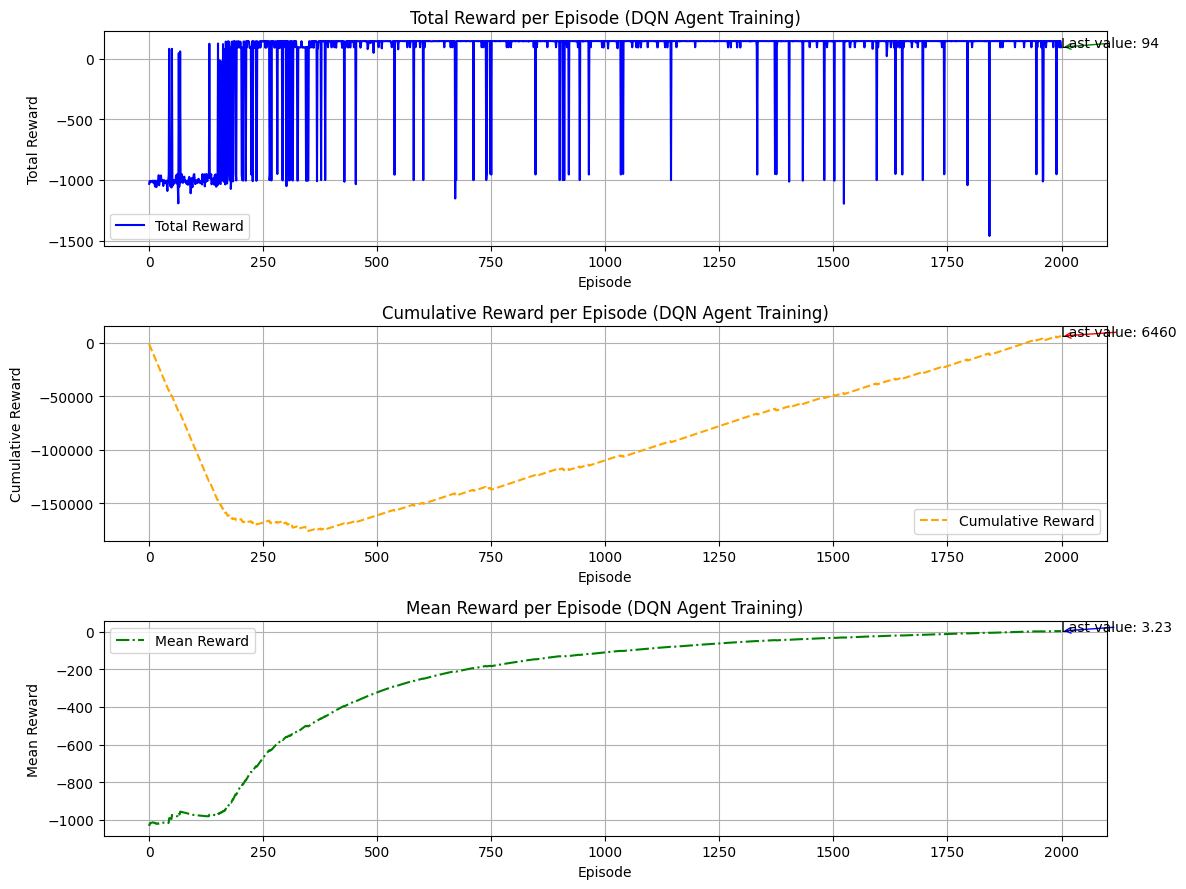

In [7]:
def plot_rewards(total_rewards, cumulative_rewards, mean_rewards, title, filename):
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))

    axs[0].plot(total_rewards, label='Total Reward', color='blue', linestyle='-')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode ({title})')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].annotate(f'Last value: {total_rewards[-1]}', xy=(len(total_rewards)-1, total_rewards[-1]),
                    xytext=(len(total_rewards)-1, total_rewards[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color='green'))

    axs[1].plot(cumulative_rewards, label='Cumulative Reward', color='orange', linestyle='--')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Cumulative Reward')
    axs[1].set_title(f'Cumulative Reward per Episode ({title})')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].annotate(f'Last value: {cumulative_rewards[-1]}', xy=(len(cumulative_rewards)-1, cumulative_rewards[-1]),
                    xytext=(len(cumulative_rewards)-1, cumulative_rewards[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color='red'))

    axs[2].plot(mean_rewards, label='Mean Reward', color='green', linestyle='-.')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Mean Reward')
    axs[2].set_title(f'Mean Reward per Episode ({title})')
    axs[2].legend()
    axs[2].grid(True)
    axs[2].annotate(f'Last value: {mean_rewards[-1]}', xy=(len(mean_rewards)-1, mean_rewards[-1]),
                    xytext=(len(mean_rewards)-1, mean_rewards[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle='->', color='blue'))

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Initialize the environment
env = GridWorld()

# Define hyperparameters
learning_rate = 1e-4
gamma = 0.99
state_shape = (env.size * env.size * 5,)
actions = 8
batch_size = 64

# Create the agent
agent = DQNetworkAgent(learning_rate, gamma, state_shape, actions, batch_size)

# Train the agent
episodes = 2000
total_rewards, cumulative_rewards, mean_rewards = agent.train(env, episodes)

# Plot the results
plot_rewards(total_rewards, cumulative_rewards, mean_rewards, "DQN Agent Training", "dqn_training_rewards.png")

# DQN results for Comparison part:
DQNtotal_rewards = total_rewards
DQNcumulative_rewards = cumulative_rewards
DQNmean_rewards = mean_rewards

